In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from ultralytics import FastSAM
from scipy import stats
import matplotlib.pyplot as plt
import math

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ultralytics/nn/tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(


0: 384x640 38 objects, 303.0ms
Speed: 12.2ms preprocess, 303.0ms inference, 1269.5ms postprocess per image at shape (1, 3, 384, 640)


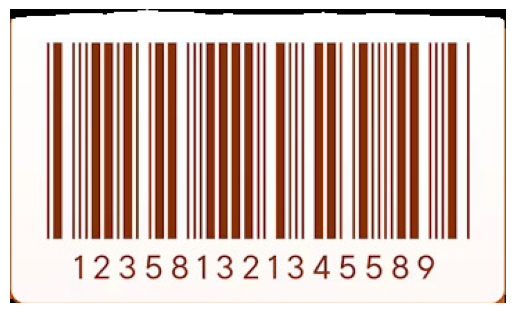

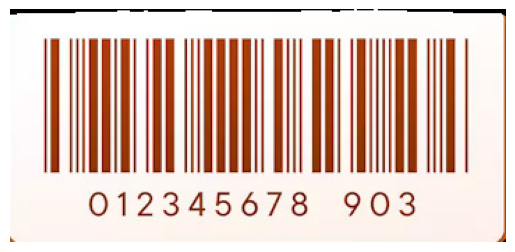

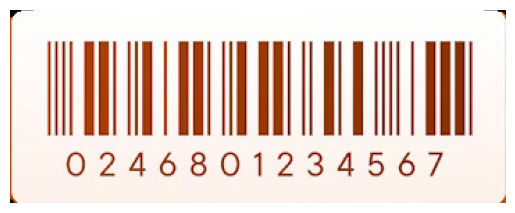

Skipping segment 3 due to size constraints
Skipping segment 4 due to size constraints
Skipping segment 5 due to size constraints
Skipping segment 6 due to size constraints
Skipping segment 7 due to size constraints
Skipping segment 8 due to size constraints
Skipping segment 9 due to size constraints
Skipping segment 10 due to size constraints
Skipping segment 11 due to size constraints
Skipping segment 12 due to size constraints
Skipping segment 13 due to size constraints
Skipping segment 14 due to size constraints
Skipping segment 15 due to size constraints
Skipping segment 16 due to size constraints
Skipping segment 17 due to size constraints
Skipping segment 18 due to size constraints
Skipping segment 19 due to size constraints
Skipping segment 20 due to size constraints
Skipping segment 21 due to size constraints
Skipping segment 22 due to size constraints
Skipping segment 23 due to size constraints
Skipping segment 24 due to size constraints
Skipping segment 25 due to size constra

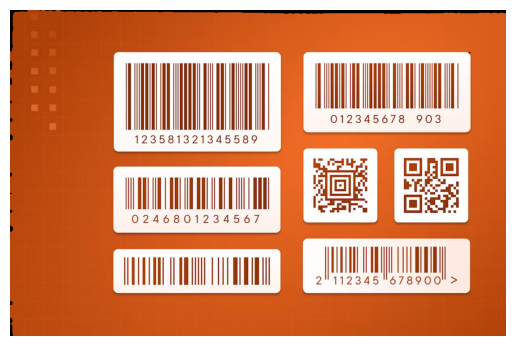

Skipping segment 36 due to size constraints
Skipping segment 37 due to size constraints


In [2]:
def check(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_32F 
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box) 
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return 1


def extract_segments(image_path):
    output_dir = "./segments1"
    os.makedirs(output_dir, exist_ok=True)
    model = FastSAM('FastSAM-s.pt')
    original_image = Image.open(image_path)
    image_np = np.array(original_image)
    image_area = original_image.size[0] * original_image.size[1]
    results = model(original_image, device='cuda' if torch.cuda.is_available() else 'cpu',
                    retina_masks=True, conf=0.4, iou=0.9)
    annotations = results[0].masks.data
    if annotations is None:
        print("No segments detected")
        return []
    segments = []
    for idx, annotation in enumerate(annotations):
        mask = annotation.cpu().numpy()
        mask = cv2.resize(mask, (original_image.size[0], original_image.size[1]))
        mask = mask > 0.5
        segment = np.zeros_like(image_np)
        
        segment[mask] = image_np[mask]
        
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
            if bbox_area < 0.05 * image_area or bbox_area > 0.9 * image_area:
                print(f"Skipping segment {idx} due to size constraints")
                continue
    
            cropped_segment = segment[y_min:y_max+1, x_min:x_max+1]
            if(check(cropped_segment)==0):
                print(f"Skipping segment {idx} due to segmenation problem")
                continue
            cv2.imwrite(f"{output_dir}/segment_{idx}.png", cv2.cvtColor(cropped_segment, cv2.COLOR_RGB2BGR))
            segments.append({'index': idx, 'mask': mask, 'cropped_segment': cropped_segment})
    
    return segments

def main():
    image_path = "/Users/sanchitjalan/Desktop/5th_sem/DIP/new/DIP_Project/1.jpg"
    
    try:
        segments = extract_segments(image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [8]:
import zbar
from PIL import Image

# Initialize the scanner
scanner = zbar.ImageScanner()
scanner.parse_config('enable')

# Path to the image
image_path = "/Users/sanchitjalan/Desktop/5th_sem/DIP/new/DIP_Project/rotated_segments/rotated_segment_1.png"

# Load the image using PIL
pil_image = Image.open(image_path).convert('L')  # Convert to grayscale

# Get image dimensions
width, height = pil_image.size
raw_data = pil_image.tobytes()

# Create a zbar image
zbar_image = zbar.Image(width, height, 'Y800', raw_data)

# Scan the image
scanner.scan(zbar_image)

# Process results
if zbar_image.symbols:
    for symbol in zbar_image:
        print("Type:", symbol.type)
        print("Data:", symbol.data.decode('utf-8'))
else:
    print("No barcode detected.")


AttributeError: module 'zbar' has no attribute 'ImageScanner'

Checking if diagonal decoding works

No rotation detected


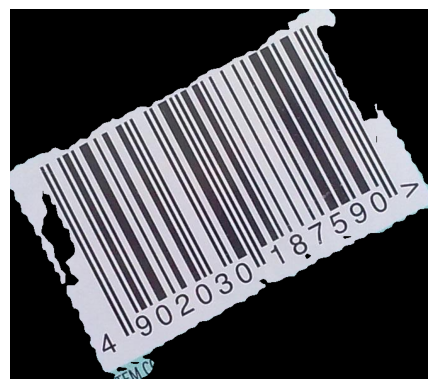

Type: EAN_13
Data: 4902030187590


In [6]:
import zxing

def check_horizontal(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            plt.plot((x1, x2), (y1, y2), 'r')
        angles = [np.degrees(theta) for rho, theta in lines[:, 0]]
        
        print("Mean of angles is: ", np.mean(angles))
        if(abs(np.mean(angles) - 90) < 5 or abs(np.mean(angles) - 270) < 5):
            
            plt.figure()
            plt.imshow(img)
            plt.axis("off")
            plt.show()
            return img
        else:
            angle = np.mean(angles) + 180  
            if(np.mean(angles) < 90):
                angle = angle + 180
        print(f"Detected angle: {angle}")

        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, M, (w, h))
    else:
        print("No rotation detected")
        rotated_img = img  

    plt.figure()
    plt.imshow(rotated_img)
    plt.axis("off")
    plt.show()

    return rotated_img

image_path = "segments/segment_3.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rotated_img = check_horizontal(img)

os.makedirs("rotated_segments", exist_ok=True)
cv2.imwrite("rotated_segments/rotated_segment.png", cv2.cvtColor(rotated_img, cv2.COLOR_RGB2BGR))

rotated_path = "rotated_segments/rotated_segment.png"
reader = zxing.BarCodeReader()
barcode1 = reader.decode(rotated_path)
if barcode1:
    print("Type:", barcode1.format)
    print("Data:", barcode1.raw)
else:
    print("No barcode detected.")

In [201]:
from pyzbar.pyzbar import decode

def read_barcode(img_path):

    image = cv2.imread(img_path)
    if image is None:
        return "Could not load image."

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    decoded_objects = decode(gray)

    if not decoded_objects:
        return "No barcode detected."

    ean13_data = []
    for obj in decoded_objects:
        if obj.type == "EAN13":  
            barcode_data = obj.data.decode('utf-8')
            ean13_data.append(barcode_data)
            print(f"EAN-13 Barcode: {barcode_data}")

            points = obj.polygon
            if len(points) > 4:  
                hull = cv2.convexHull(np.array([point for point in points], dtype=np.float32))
                points = hull.squeeze().tolist()

            n = len(points)
            for j in range(n):
                pt1 = tuple(map(int, points[j]))
                pt2 = tuple(map(int, points[(j + 1) % n]))
                cv2.line(image, pt1, pt2, (0, 255, 0), 3)
                
    return ean13_data
    
    
img_path = "rotated_segments/rotated_segment.png"
# read_barcode(img_path)
print(read_barcode(img_path))
# print(read_barcode(img_path))

EAN-13 Barcode: 4902030024888
['4902030024888']
